Jun Pan
DATA 612 Project 2 | Content-Based and Collaborative Filtering
The goal of this assignment is for you to try out different ways of implementing and configuring a recommender, and to evaluate your different approaches. 
 
For assignment 2, start with an existing dataset of user-item ratings, such as our toy books dataset, MovieLens, Jester [http://eigentaste.berkeley.edu/dataset/] or another dataset of your choosing.  Implement at least two of these recommendation algorithms: • Content-Based Filtering • User-User Collaborative Filtering • Item-Item Collaborative Filtering 
 
As an example of implementing a Content-Based recommender, you could build item profiles for a subset of MovieLens movies from scraping http://www.imdb.com/ or using the API at https://www.omdbapi.com/ (which has very recently instituted a small monthly fee).  A more challenging method would be to pull movie summaries or reviews and apply tf-idf and/or topic modeling. You should evaluate and compare different approaches, using different algorithms, normalization techniques, similarity methods, neighborhood sizes, etc.  You don’t need to be exhaustive—these are just some suggested possibilities.   You may use the course text’s recommenderlab or any other library that you want.   Please provide at least one graph, and a textual summary of your findings and recommendations. 
 
You may work in a small group.  Please submit a link to your GitHub repository for your Jupyter notebook or RMarkdown file.    

The MovieLens Dataset
One of the most common datasets that is available on the internet for building a Recommender System is the MovieLens DataSet. This version of the dataset that I'm working with (1M) contains 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000.  The data was collected by GroupLens researchers over various periods of time, depending on the size of the set. This 1M version was released on February 2003. Users were selected at random for inclusion. All users selected had rated at least 20 movies. Each user is represented by an id, and no other information is provided.  The datasets contains in three files: "movies", "ratings" and "users".

LOAD DATA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading ratings file
# Ignore the timestamp column
ratings = pd.read_csv('C:/Users/tbao/Desktop/CUNY MSDS notes/DATA612/project 2/working folder/ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])

# Reading users file
users = pd.read_csv('C:/Users/tbao/Desktop/CUNY MSDS notes/DATA612/project 2/working folder/users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('C:/Users/tbao/Desktop/CUNY MSDS notes/DATA612/project 2/working folder/movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

In [ ]:
OVERVIEW RATINGS DATASET

In [3]:
print(ratings.head())
print(ratings.info())

   user_id  movie_id  rating
0        1      1193       5
1        1       661       3
2        1       914       3
3        1      3408       4
4        1      2355       5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
user_id     1000209 non-null int64
movie_id    1000209 non-null int64
rating      1000209 non-null int64
dtypes: int64(3)
memory usage: 22.9 MB
None


In [4]:
ratings['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

(array([ 56174.,      0., 107557.,      0.,      0., 261197.,      0.,
        348971.,      0., 226310.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

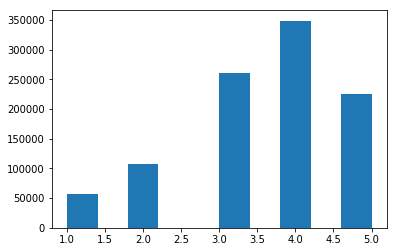

In [7]:
plt.hist(ratings["rating"])

COMMENTS:Users are very generous to rate the movies.  So the overall distribution of ratings are right skewed. 

In [ ]:
OVERVIEW OF USERS DATASET

In [8]:
print(users.head())
print(users.info())

   user_id gender zipcode  age_desc              occ_desc
0        1      F   48067  Under 18          K-12 student
1        2      M   70072       56+         self-employed
2        3      M   55117     25-34             scientist
3        4      M   02460     45-49  executive/managerial
4        5      M   55455     25-34                writer
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
user_id     6040 non-null int64
gender      6040 non-null object
zipcode     6040 non-null object
age_desc    6040 non-null object
occ_desc    6040 non-null object
dtypes: int64(1), object(4)
memory usage: 236.0+ KB
None


In [9]:
users['gender'].describe()

count     6040
unique       2
top          M
freq      4331
Name: gender, dtype: object

In [10]:
users['age_desc'].describe()

count      6040
unique        7
top       25-34
freq       2096
Name: age_desc, dtype: object

In [11]:
users['occ_desc'].describe()

count                     6040
unique                      21
top       college/grad student
freq                       759
Name: occ_desc, dtype: object

MOVIES DATASET

In [13]:
print(movies.head())
print(movies.info())

   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
movie_id    3883 non-null int64
title       3883 non-null object
genres      3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None


OVERVIEW MOVIELENs DATASETS AFTER MERGE

In [14]:
data = pd.merge(pd.merge(ratings, users), movies)

In [18]:
data[:15]

,user_id,movie_id,rating,gender,zipcode,age_desc,occ_desc,title,genres
0,1,1193,5,F,48067,Under 18,K-12 student,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,M,70072,56+,self-employed,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,M,32793,25-34,programmer,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,M,22903,25-34,executive/managerial,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,M,95350,50-55,academic/educator,One Flew Over the Cuckoo's Nest (1975),Drama
5,18,1193,4,F,95825,18-24,clerical/admin,One Flew Over the Cuckoo's Nest (1975),Drama
6,19,1193,5,M,48073,Under 18,K-12 student,One Flew Over the Cuckoo's Nest (1975),Drama
7,24,1193,5,F,10023,25-34,executive/managerial,One Flew Over the Cuckoo's Nest (1975),Drama
8,28,1193,3,F,14607,25-34,academic/educator,One Flew Over the Cuckoo's Nest (1975),Drama
9,33,1193,5,M,55421,45-49,clerical/admin,One Flew Over the Cuckoo's Nest (1975),Drama


In [19]:
mean_ratings = data.pivot_table('rating', index='title',
                                columns='gender', aggfunc='mean')

In [20]:
mean_ratings[:10]

gender,F,M
title,,
"$1,000,000 Duck (1971)",3.375000,2.761905
'Night Mother (1986),3.388889,3.352941
'Til There Was You (1997),2.675676,2.733333
"'burbs, The (1989)",2.793478,2.962085
...And Justice for All (1979),3.828571,3.689024
1-900 (1994),2.000000,3.000000
10 Things I Hate About You (1999),3.646552,3.311966
101 Dalmatians (1961),3.791444,3.500000
101 Dalmatians (1996),3.240000,2.911215


In [28]:
# Display 15 movies with highest rating
dataset = pd.merge(pd.merge(movies, ratings),users)
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(15)

,title,genres,rating
0,Toy Story (1995),Animation|Children's|Comedy,5
489283,American Beauty (1999),Comedy|Drama,5
489259,Election (1999),Comedy,5
489257,"Matrix, The (1999)",Action|Sci-Fi|Thriller,5
489256,Dead Ringers (1988),Drama|Thriller,5
489237,Rushmore (1998),Comedy,5
489236,"Simple Plan, A (1998)",Crime|Thriller,5
489226,Hands on a Hard Body (1996),Documentary,5
489224,Pleasantville (1998),Comedy,5
489212,Say Anything... (1989),Comedy|Drama|Romance,5


SORT MOST POPULAR WORDS IN TITLE 

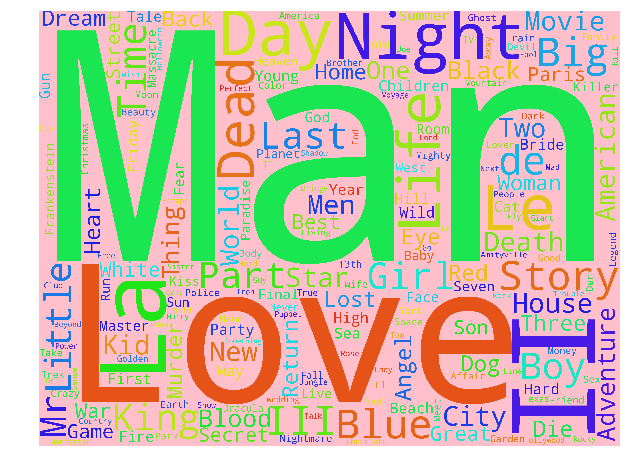

In [31]:
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='pink', height=3000, width=4000).generate(title_corpus)
plt.figure(figsize=(20,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

RANK OG GENRES 

In [32]:
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:18]

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471],
 ['Horror', 343],
 ['Adventure', 283],
 ['Sci-Fi', 276],
 ["Children's", 251],
 ['Crime', 211],
 ['War', 143],
 ['Documentary', 127],
 ['Musical', 114],
 ['Mystery', 106],
 ['Animation', 105],
 ['Fantasy', 68],
 ['Western', 68],
 ['Film-Noir', 44]]

In [ ]:
CONTENT BASED RECOMMENDATION ENGINE

Items (content) are described by a feature set and we use only the target user’s history. A content based recommender works with data that the user provides, either explicitly movie ratings for the MovieLens dataset. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.
Implementation: To build a Content-Based Recommendation Engine that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre by using the file movies.csv.

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].fillna("").astype('str')
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

(3883, 127)

In [35]:
#Calculate cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.14193614, 0.09010857, 0.1056164 ],
       [0.14193614, 1.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 ],
       [0.1056164 , 0.        , 0.1719888 , 1.        ]])

In [36]:
#Write a function to generate similar movie based on genres.
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

TEST THE CONTENT BASED RECOMMENDATION ENGINE

In [37]:
genre_recommendations('Rushmore (1998)').head(20)

18                 Ace Ventura: When Nature Calls (1995)
37                                   It Takes Two (1995)
51                               Mighty Aphrodite (1995)
62     Don't Be a Menace to South Central While Drink...
64                                       Bio-Dome (1996)
68                                         Friday (1995)
87                                    Black Sheep (1996)
94                         In the Bleak Midwinter (1995)
99                                  Bottle Rocket (1996)
100                                     Mr. Wrong (1996)
102                                 Happy Gilmore (1996)
107                  Headless Body in Topless Bar (1995)
113                     Happiness Is in the Field (1995)
117                       Steal Big, Steal Little (1995)
123                        Flirting With Disaster (1996)
133                                Down Periscope (1996)
139                                 Birdcage, The (1996)
142                        Brot

In [40]:
genre_recommendations('Happy Gilmore (1996)').head(5)

18                Ace Ventura: When Nature Calls (1995)
37                                  It Takes Two (1995)
51                              Mighty Aphrodite (1995)
62    Don't Be a Menace to South Central While Drink...
64                                      Bio-Dome (1996)
Name: title, dtype: object

In [41]:
genre_recommendations('American Beauty (1999)').head(8)

44                              To Die For (1995)
71                   Kicking and Screaming (1995)
74                               Big Bully (1996)
83             Last Summer in the Hamptons (1995)
104    Nobody Loves Me (Keiner liebt mich) (1994)
131                              Nueba Yol (1995)
164                   Doom Generation, The (1995)
203                        Unstrung Heroes (1995)
Name: title, dtype: object

Pros:
1. Unlike Collaborative Filtering, if the items have sufficient descriptions, we avoid the “new item problem”.
2. Content representations are varied and they open up the options to use different approaches like: text processing techniques, the use of semantic information, inferences, etc…
3. It is easy to make a more transparent system: we use the same content to explain the recommendations.

Cons:
1. Content-Based RecSys tend to over-specialization: they will recommend items similar to those already consumed, with a tendecy of creating a “filter bubble”.
2. The methods based on Collaborative Filtering have shown to be, empirically, more precise when generating recommendations.

COLLABORATIVE FILTERING RECOMMENDATION ENGINES

The content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. Because it is not capable of capturing tastes and providing recommendations across genres.  Also, the engine that we built is not really personal because it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.  So Memory-Based Collaborative Filtering Models will be build to make recommendations to movie users. The technique is based on the idea that users similar to us can be used to predict how much we will like a particular product or service those users have used/experienced but we have not.

There are 2 main types of memory-based collaborative filtering algorithms:
1.  User-Based Collaborative Filtering (UB-CF)
    Imagine that we want to recommend a movie to our friend Stanley. We could assume that similar people will have similar taste. Suppose that me and Stanley have seen the same movies, and we rated them all almost identically. But Stanley hasn’t seen ‘The Godfather: Part II’ and I did. If I love that movie, it sounds logical to think that he will too. With that, we have created an artificial rating based on our similarity.
    
PROS:
    Easy to implement.
    Context independent.
    Compared to other techniques, such as content-based, it is more accurate.
CONS:
    Sparsity: The percentage of people who rate items is really low.
    Scalability: The more K neighbors we consider (under a certain threshold), the better my classification should be. Nevertheless, the more users there are in the system, the greater the cost of finding the nearest K neighbors will be.
    Cold-start: New users will have no to little information about them to be compared with other users.
    New item: Just like the last point, new items will lack of ratings to create a solid ranking (More of this on ‘How to sort and rank items’).


2. Item-Based Collaborative Filtering (IB-CF)
    Back to Stanley. Instead of focusing on his friends, we could focus on what items from all the options are more similar to what we know he enjoys. This new focus is known as Item-Based Collaborative Filtering (IB-CF).
    
    The difference between UB-CF and this method is that, in this case, we directly pre-calculate the similarity between the co-rated items, skipping K-neighborhood search.
    
    5 features of this model:
1. Easy to implement and maintain.
2. Updatable online: new ratings should change predictions quickly.
3. Efficient at the time of consultation: storage is the main cost.
4. It works with little user feedback.
5. Reasonably accurate, within certain ranges in which a small gain in accuracy does not mean a great sacrifice of simplicity and scalability.

IMPLEMENTATION
1. Ratings dataset will be used.
2. Due to limited power of computer, 1% of data (about 10,000 observers) will be used in this study.

In [44]:
# Deal with NAs
ratings['user_id'] = ratings['user_id'].fillna(0)
ratings['movie_id'] = ratings['movie_id'].fillna(0)
ratings['rating'] = ratings['rating'].fillna(ratings['rating'].mean())

# Random subset 1% of the ratings dataset (mini_data)
mini_data = ratings.sample(frac=0.01)
print(mini_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 146786 to 284581
Data columns (total 3 columns):
user_id     10002 non-null int64
movie_id    10002 non-null int64
rating      10002 non-null int64
dtypes: int64(3)
memory usage: 312.6 KB
None


In [45]:
# Split train data (80%) and Test data (20%)
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(mini_data, test_size=0.2)

# Create two user-item matrices, one for training and another for testing
train_data_matrix = train_data.as_matrix(columns = ['user_id', 'movie_id', 'rating'])
test_data_matrix = test_data.as_matrix(columns = ['user_id', 'movie_id', 'rating'])
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(8001, 3)
(2001, 3)


C:\Users\tbao\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\tbao\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


Using "pairwise_distances" function from sklearn to calculate "Pearson Correlation Coefficient". Then, User Smilarity Matrix and Item Similarity Matrix will be built.

In [46]:
#Build User Similarity Matrix
from sklearn.metrics.pairwise import pairwise_distances

user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

[[ 1.          0.19199916  0.97901041  0.99944251]
 [ 0.19199916  1.         -0.0120492   0.22465755]
 [ 0.97901041 -0.0120492   1.          0.9716601 ]
 [ 0.99944251  0.22465755  0.9716601   1.        ]]


In [47]:
#Build Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[ 1.         -0.01410781  0.0070896 ]
 [-0.01410781  1.         -0.05119732]
 [ 0.0070896  -0.05119732  1.        ]]


With both User similarity Matrix and Item Similarity Matrix, we can predict the ratings that were not included in our datasets. Using these predictions, we can compare the results with the test data to validate the quality of our recommender model.  For user-user CF cases, we will look at the similarity between 2 users (A and B, for example) as weights that are multiplied by the ratings of a similar user B (corrected for the average rating of that user). We also need to normalize it so that the ratings stay between 1 and 5.  At end, sum the average ratings for the user that we will try to predict. The reason to normalize the data is that some users may tend always to give high or low ratings to all movies. The relative difference in the ratings that these users give is more important than the absolute values.

In [48]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

EVALUATION MODELS BY RMSE

In [53]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [54]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 1433.4161028739816
Item-based CF RMSE: 1653.2428972010175


In [55]:
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

User-based CF RMSE: 698.3492685023438
Item-based CF RMSE: 124.53970427332925


In general, we can see the RMSE values are quite big.  Because we have limited information to make recommendation in this case.  Interestingly, RMSE is smaller in User based model than Item based model in test  dataset.  In contrary, RMSE is bigger in User based dataset than Item based dataset in train dataset.

In summary, Memory-based Collaborative Filtering is easy to implement and produce reasonable prediction quality. However, there are some drawback of this approach:

It doesn't address the well-known cold-start problem, for example, when new user or new item enters the system.
It can't deal with sparse data, which means it's hard to find users that have rated the same items.
It suffers when new users or items that don't have any ratings enter the system.
It tends to recommend popular items.